In [31]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/pendulum_problem")

# Outline
1. PID
2. Full State Feedback
3. LQR

In [32]:
from control.matlab import *
import numpy as np
import gym
from CartPoleEnv import CartPoleEnv

In [33]:
# let's define state space representation
env = CartPoleEnv()

/home/tasbolat/tas_python_env/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


## Define problem

Dynamics of the problem is given as following:
\begin{equation}
\ddot{ \theta } = \frac{ gsin{\theta} + cos{\theta} ( \frac{-F-m_p\dot{\theta}^2sin{\theta}}{m_c + m_p}) } {l (\frac{4}{3} - \frac{m_pcos^2{\theta}}{m_c+m_p})}
\end{equation}

\begin{equation}
\ddot{x} = \frac{F+m_pl(\dot{\theta}^2sin{\theta} - \ddot{\theta}cos{\theta})}{m_c+m_p}
\end{equation}

Linearize around $x=0$, $\dot{x}=0$, $\theta=0$ and $\dot{\theta}=0$:
\begin{equation}
x = \begin{bmatrix}
p\\
\dot{p}\\
\theta\\
\dot{\theta}
\end{bmatrix}
\end{equation}
\begin{equation}
A = \begin{bmatrix}
0 & 1 & 0 & 0\\
0 & 0 & \frac{-12m_pg}{13m_c+m_p} & 0\\
0 & 0 & 0 & 1\\
0 & 0 & \frac{12g(m_p + m_c)}{13m_c+m_p} & 0
\end{bmatrix}
\end{equation}
\begin{equation}
B = \begin{bmatrix}
0\\
\frac{13}{13m_c+m_p}\\
0\\
\frac{-12}{13m_c+m_p}
\end{bmatrix}
\end{equation}

then,
continious state space representation:
$$\dot{x}(t) = Ax(t) + Bu(t) $$
$$\dot{y}(t) = x(t)$$

In [140]:
A = np.array( [[0, 1, 0, 0],
               [0, 0, -12*env.masspole*env.force_mag/(13*env.masscart + env.masspole), 0],
              [0, 0, 0, 1],
              [0, 0, 12*(env.masspole*env.force_mag + env.masscart*env.force_mag)/(env.length*(13*env.masscart + env.masspole)) , 0]] )
B= np.array( [[0], [13/(13*env.masscart + env.masspole)], [0], [-12/(env.length*(13*env.masscart + env.masspole))]] )
C = np.array( [1, 1, 1, 1] )
D = 0

In [142]:
sys = StateSpace(A, B, C, D)

In [145]:
ss2tf(sys)


        -0.8397 s^3 - 0.8397 s^2 - 18.32 s - 18.32
---------------------------------------------------------
s^4 + 2.665e-15 s^3 - 20.15 s^2 + 5.684e-14 s + 2.753e-14

In [96]:
# let's define pid feedback
Kp = 1
Ki = 0
Kd = 75

In [97]:
feedback_gain_sys = Kp*tf('s') + Ki*tf('s') + Kd*tf('s')/( env.tau * tf('s') + 1 )

In [111]:
closed_loop_PID = feedback(ss2tf(sys)*feedback_gain_sys, 1) 

In [112]:
pole( closed_loop_PID )

array([ 1.95991242e+04+0.j        , -2.08749814e-02+4.73755711j,
       -2.08749814e-02-4.73755711j, -9.87237240e-01+0.j        ,
        1.97746303e-17+0.j        ])

(array([ 1.95991242e+04+0.j        , -2.08749814e-02+4.73755711j,
        -2.08749814e-02-4.73755711j, -9.87237240e-01+0.j        ,
         1.97746303e-17+0.j        ]),
 array([-3.80000000e+03+0.j        , -5.55111512e-16+4.67099366j,
        -5.55111512e-16-4.67099366j, -1.00000000e+00+0.j        ,
         0.00000000e+00+0.j        ]))

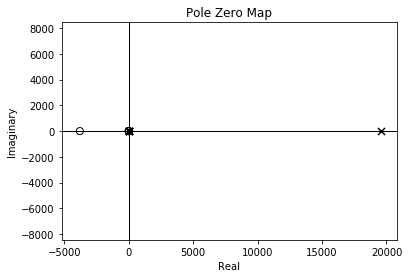

In [146]:
pzmap(closed_loop_PID)

PID:
1. Mostly designed for SISO systems (use something else for MIMO)
2. Cannot easily achieve stable results if system is non-linear
3. Integral Windup -> cannot be easily solved

## Full State Feedback

![alt text](pole_placement.png "Title")

In [139]:
poles = np.array([-15, -6, -7, -1]) # seems very stable
K_FSF = place(A, B, poles)
K_FSF

matrix([[ -34.3875    ,  -47.32375   , -174.27239583,  -41.46286458]])

In [148]:
A_fsb = A-K_FSF*B

FSF:
1. Sometimes control is expensive, cannot afford
2. Balancing between states and control unput is not intuitive

## LQR

In [127]:
Q = np.eye(4)*0.1 # can make more mistake here
R = np.eye(1)*100 # control is expensive

simply, minimize this cost
$$J = \int_0^{\infty} x^T(t)Qx(t) + u^T(t)Ru(t)$$

In [128]:
K, S, E = lqr(A, B, Q, R)

In [129]:
K

matrix([[ -0.03162278,  -0.27975715, -23.21652068,  -5.18415829]])

In [157]:
E

array([-4.5175486 +0.j        , -4.4610095 +0.j        ,
       -0.12075746+0.11901846j, -0.12075746-0.11901846j], dtype=complex64)

LQR:
1. Great, but system shall be linear
2. Model must be known

Read up:
1. iLQR (iterative version) - extension of LQR
2. 